# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [34]:
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

import warnings
warnings.filterwarnings("ignore")

In [19]:
# import sys
# !{sys.executable} -m pip install spacy
# print(sys.executable)
# import nltk
# nltk.download('brown')

In [62]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [21]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [22]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [29]:
df.head()

,category,id,text,char_len,word_len
0,editorial,cb01,Assembly session brought much good The General...,12659,2200
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra...",11871,2244
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...,12284,2230
4,editorial,cb05,Help when needed If the Dominican Republic ach...,12479,2241


In [23]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<AxesSubplot:xlabel='category'>

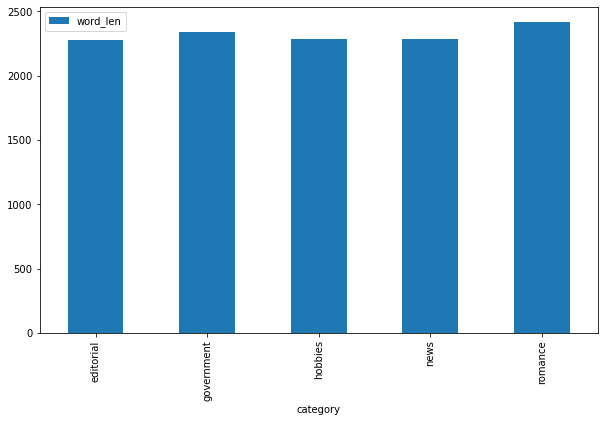

In [25]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [27]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

(166, 4941)

In [28]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: In count_text_vectors, each cell represents the term frequency (frequency of a term in a document), while in tfidf_text_vectors, each cell represents the TF-IDF value. TF-IDF combines the term frequency and inverse document frequency to measure the importance of a term in a document relative to the entire corpus.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [30]:
# fit a five-topic NMF model
nmf_text_model = NMF(n_components=5, random_state=7)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [31]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [86]:
# For each topic in your NMF model, tally the Brown categories
topic_to_category = defaultdict(lambda: defaultdict(int))

for idx, row in enumerate(W_text_matrix):
    topic = np.argmax(row)
    category = df['category'].iloc[idx]
    topic_to_category[topic][category] += 1
topic_to_category 

defaultdict(<function __main__.<lambda>()>,
            {2: defaultdict(int,
                         {'editorial': 2,
                          'government': 26,
                          'news': 11,
                          'hobbies': 26}),
             0: defaultdict(int,
                         {'editorial': 20, 'government': 4, 'news': 8}),
             1: defaultdict(int,
                         {'editorial': 4, 'romance': 29, 'hobbies': 8}),
             4: defaultdict(int, {'editorial': 1, 'news': 8, 'hobbies': 1}),
             3: defaultdict(int, {'news': 17, 'hobbies': 1})})

Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The five-topic NMF model shows some agreement with the original Brown categories. For example, topic 02, which is dominated by terms such as "state," "tax," "program," and "development," seems to align well with the 'government' category. Similarly, topic 00, with terms like "mr," "president," "kennedy," and "united," appears to fit with categories such as 'government,' 'news,' or 'editorial. However, topic 01 and 03 with term like "mrs," "miss," "car," and "said" or  "said," "didn," "thought," and "man" are harder to intepret if it is 'romance', 'hobies', or 'news'. 


## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [89]:
# Fit the LSA model
lsa_text_model = TruncatedSVD(n_components=5, random_state=7)
lsa_text_matrix = lsa_text_model.fit_transform(tfidf_text_vectors)

In [92]:
# For each topic in your NMF model, tally the Brown categories
topic_to_category = defaultdict(lambda: defaultdict(int))

for idx, row in enumerate(lsa_text_matrix):
    topic = np.argmax(row)
    category = df['category'].iloc[idx]
    topic_to_category[topic][category] += 1
topic_to_category 

defaultdict(<function __main__.<lambda>()>,
            {0: defaultdict(int,
                         {'editorial': 27,
                          'government': 30,
                          'news': 34,
                          'romance': 21,
                          'hobbies': 36}),
             4: defaultdict(int, {'news': 7}),
             3: defaultdict(int, {'news': 3}),
             1: defaultdict(int, {'romance': 8})})

Q: How does your five-topic LSA model compare to the original Brown categories? 

A: Topic 0 seems to dominate in all categories while topic 4 seems to be particularly associated with the "news" category, topic 3 also relates to the "news" category, and topic 1 is relates "romance" category. We could see that topic 2 missing which show that it has no strong connection to any of the categories. 


In [91]:
# call display_topics on your model
display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.17)
  mr (1.69)
  said (1.06)
  kennedy (0.78)
  khrushchev (0.76)

Topic 03
  mrs (27.04)
  club (6.03)
  game (5.52)
  jr (5.17)
  university (4.72)

Topic 04
  game (4.12)
  league (2.95)
  baseball (2.94)
  ball (2.82)
  team (2.68)


Q: What is your interpretation of the display topics output? 

A: With the display topics output of the LSA model, some interpretation can be made such as: topic 00, 01, 02 is more like story or talk about individuals which are hard to intepret while topic 03 is likely to be about sport or hobbies, and topic 04 is about baseball or sports-related.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. t

In [99]:
# Fit the LDA model
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=7)
lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)

In [101]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  use (0.59)
  water (0.45)
  work (0.38)
  good (0.37)
  high (0.35)

Topic 01
  said (1.41)
  man (0.58)
  old (0.53)
  little (0.49)
  know (0.43)

Topic 02
  said (0.65)
  state (0.61)
  president (0.55)
  tax (0.43)
  city (0.35)

Topic 03
  mrs (1.52)
  mr (0.53)
  clay (0.44)
  work (0.39)
  student (0.38)

Topic 04
  state (1.41)
  states (1.32)
  united (1.23)
  government (0.89)
  shall (0.71)


In [102]:
# For each topic in your NMF model, tally the Brown categories
topic_to_category = defaultdict(lambda: defaultdict(int))

for idx, row in enumerate(lda_text_matrix):
    topic = np.argmax(row)
    category = df['category'].iloc[idx]
    topic_to_category[topic][category] += 1
topic_to_category 

defaultdict(<function __main__.<lambda>()>,
            {2: defaultdict(int,
                         {'editorial': 13,
                          'government': 14,
                          'news': 28,
                          'hobbies': 3}),
             1: defaultdict(int,
                         {'editorial': 11,
                          'government': 1,
                          'news': 6,
                          'romance': 29,
                          'hobbies': 5}),
             3: defaultdict(int,
                         {'editorial': 1,
                          'government': 2,
                          'news': 9,
                          'hobbies': 8}),
             4: defaultdict(int,
                         {'editorial': 2,
                          'government': 8,
                          'news': 1,
                          'hobbies': 1}),
             0: defaultdict(int, {'government': 5, 'hobbies': 19})})

Q: What inference do you draw from the displayed topics for your LDA model? 

A: Topic 00 seems to focus on the use of water, work, and quality. Topic 01 may be discussion about a man, and his age. Topic 02 involves discussions related to the state, president, taxes, and cities. Topic 03 focuses on individuals such as Mrs., Mr., work, and students. Topic 04 is about the state, United States, government.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: Mosts topics from LDA model contains different Brown categories. Topic 2 and 4 seems most aligned to the ctergory of government, editorials and news. Other topics are hareder to compare. 

In [76]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [70]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: The principal component scatterplot shows distribution of topics with topic 3 and topic 2 appear to have the largest representation within the dataset indicating these two topics have a higher frequency compared to other topics. Also it could also be seen that  3 and 5 are most similar to each other as well as 2 and 4 to each other. On the other hand, topic 1 seem to be most different from other topics. in addition, the salient terms graph displays the most relevant terms for each topic, highlighting their importance and prevalence within the corpus. It helps to identify the key themes and concepts associated with each topic. These graphs provide such good details and valuable insight.

